In [1]:
# Lung Cancer Detection Using Pretrained CNNs with Stratified Sampling and Class Balancing

# ❗ NOTE: This notebook requires PyTorch. If running in an environment without it, please install via pip:
# !pip install torch torchvision

# ✅ 1. Setup
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
from PIL import Image
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.utils.class_weight import compute_class_weight

try:
    import torch
    import torch.nn as nn
    import torch.utils.checkpoint
    import torchvision.transforms as transforms
    from torch.utils.data import Dataset, DataLoader, Subset
    from torchvision import models
except ModuleNotFoundError:
    print("⚠️ PyTorch is not installed. Please run the following in a code cell:")
    print("!pip install torch torchvision")
    raise

In [3]:
 #✅ 2. Dataset Loader
class LungCancerClassificationDataset(Dataset):
    def __init__(self, root_dirs, class_names, transform=None):
        self.samples = []
        self.transform = transform
        self.class_to_idx = {class_name: idx for idx, class_name in enumerate(class_names)}

        for class_name, path in zip(class_names, root_dirs):
            for img_name in os.listdir(path):
                img_path = os.path.join(path, img_name)
                if img_path.lower().endswith(('.png', '.jpg', '.jpeg')):
                    self.samples.append((img_path, self.class_to_idx[class_name]))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        img_path, label = self.samples[idx]
        image = Image.open(img_path).convert("L")
        if self.transform:
            image = self.transform(image)
        return image, label


In [4]:

# ✅ 3. Evaluation Metrics
def evaluate_model(model, dataloader, device, num_classes):
    model.eval()
    y_true, y_pred, y_scores = [], [], []

    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            probs = torch.softmax(outputs, dim=1)
            preds = torch.argmax(probs, dim=1)

            y_true.extend(labels.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())
            y_scores.extend(probs.cpu().numpy())

    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    y_scores = np.array(y_scores)
    y_true_bin = label_binarize(y_true, classes=list(range(num_classes)))

    acc = accuracy_score(y_true, y_pred)
    auc = roc_auc_score(y_true_bin, y_scores, multi_class='ovr')
    cm = confusion_matrix(y_true, y_pred)

    metrics = {
        "accuracy": acc,
        "auc": auc,
    }

    for i in range(num_classes):
        TP = cm[i, i]
        FN = cm[i, :].sum() - TP
        FP = cm[:, i].sum() - TP
        TN = cm.sum() - (TP + FP + FN)
        sensitivity = TP / (TP + FN + 1e-6)
        specificity = TN / (TN + FP + 1e-6)
        metrics[f"sensitivity_class_{i}"] = sensitivity
        metrics[f"specificity_class_{i}"] = specificity

    return metrics


In [5]:
# ✅ 4. GPU Memory Management

def free_gpu_memory():
    if torch.cuda.is_available():
        torch.cuda.empty_cache()


def enable_gradient_checkpointing(model, model_name):
    """
    Enable gradient checkpointing to reduce memory usage during training.
    This trades computation for memory by not storing all activations.
    """
    def forward_hook(module, inputs, output):
        # Add .clone() to fix the in-place operation conflict
        return torch.utils.checkpoint.checkpoint(lambda x: x.clone(), output)

    if model_name == "ResNet50":
        model.layer1.apply(lambda m: m.register_forward_hook(forward_hook))
        model.layer2.apply(lambda m: m.register_forward_hook(forward_hook))
        model.layer3.apply(lambda m: m.register_forward_hook(forward_hook))
        model.layer4.apply(lambda m: m.register_forward_hook(forward_hook))

    elif model_name == "DenseNet121":
        model.features.denseblock1.apply(lambda m: m.register_forward_hook(forward_hook))
        model.features.denseblock2.apply(lambda m: m.register_forward_hook(forward_hook))
        model.features.denseblock3.apply(lambda m: m.register_forward_hook(forward_hook))
        model.features.denseblock4.apply(lambda m: m.register_forward_hook(forward_hook))

    elif model_name == "EfficientNetB0":
        for block in model.features:
            if isinstance(block, nn.Sequential):
                block.apply(lambda m: m.register_forward_hook(forward_hook))

    elif model_name == "VGG19":
        features_length = len(model.features)
        chunk_size = features_length // 4
        for i in range(0, features_length, chunk_size):
            for j in range(i, min(i + chunk_size, features_length)):
                if isinstance(model.features[j], nn.Conv2d):
                    model.features[j].register_forward_hook(forward_hook)


def get_optimal_batch_size(model_name, available_memory_mb=4000):
    """
    Estimate optimal batch size based on model and available memory.
    This is a simplified estimation.
    """
    model_memory_requirements = {
        "ResNet50": 100,       # MB per sample
        "DenseNet121": 80,     # MB per sample
        "EfficientNetB0": 30,  # MB per sample
        "VGG19": 120           # MB per sample
    }

    memory_per_sample = model_memory_requirements.get(model_name, 100)
    batch_size = int((available_memory_mb * 0.8) / memory_per_sample)
    return max(4, min(batch_size, 64))


In [6]:
# ✅ 5. Model Architecture Modifications
# Updated model definitions with weights
from torchvision import models
from torchvision.models import (
    ResNet50_Weights,
    DenseNet121_Weights,
    EfficientNet_B0_Weights,
    VGG19_Weights
)

import torch.nn as nn

def get_model(model_name, num_classes=3):
    if model_name == "ResNet50":
        model = models.resnet50(weights=ResNet50_Weights.IMAGENET1K_V1)
        model.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
        model.fc = nn.Linear(model.fc.in_features, num_classes)

    elif model_name == "DenseNet121":
        model = models.densenet121(weights=DenseNet121_Weights.IMAGENET1K_V1)
        model.features.conv0 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
        model.classifier = nn.Linear(model.classifier.in_features, num_classes)

    elif model_name == "EfficientNetB0":
        model = models.efficientnet_b0(weights=EfficientNet_B0_Weights.IMAGENET1K_V1)
        model.features[0][0] = nn.Conv2d(1, 32, kernel_size=3, stride=2, padding=1, bias=False)
        model.classifier[1] = nn.Linear(model.classifier[1].in_features, num_classes)

    elif model_name == "VGG19":
        model = models.vgg19(weights=VGG19_Weights.IMAGENET1K_V1)
        model.features[0] = nn.Conv2d(1, 64, kernel_size=3, padding=1)
        model.classifier[6] = nn.Linear(model.classifier[6].in_features, num_classes)

    else:
        raise ValueError(f"Model '{model_name}' is not supported.")

    return model


In [7]:

# ✅ 6. Training with Mixed Precision
# Updated mixed precision training with torch.amp
def train_with_mixed_precision(model, train_loader, val_loader, criterion, optimizer, scheduler, device, patience=5, max_epochs=20):
    # Initialize scaler for mixed precision
    scaler = torch.amp.GradScaler() if torch.cuda.is_available() else None
    best_val_loss = float('inf')
    counter = 0
    best_model = None

    for epoch in range(max_epochs):
        # Training phase
        model.train()
        train_loss = 0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            # Use mixed precision if available
            if scaler is not None:
                with torch.amp.autocast(device_type=device.type):
                    outputs = model(images)
                    loss = criterion(outputs, labels)

                # Scale gradients and optimize
                optimizer.zero_grad()
                scaler.scale(loss).backward()
                scaler.step(optimizer)
                scaler.update()
            else:
                outputs = model(images)
                loss = criterion(outputs, labels)
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

            train_loss += loss.item()

        avg_train_loss = train_loss / len(train_loader)

        # Validation phase - no need for mixed precision here
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()

        avg_val_loss = val_loss / len(val_loader)
        scheduler.step(avg_val_loss)

        print(f"Epoch {epoch+1}/{max_epochs}, Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}")

        # Early stopping check
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            counter = 0
            best_model = model.state_dict().copy()
        else:
            counter += 1
            if counter >= patience:
                print(f"Early stopping triggered after {epoch+1} epochs")
                break

    if best_model is not None:
        model.load_state_dict(best_model)

    return model

In [8]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [9]:

# ✅ 7. Define paths and transformations
benign_path = "/content/drive/MyDrive/Colab Notebooks/lung_cancer_dataset/Bengin cases"
malignant_path = "/content/drive/MyDrive/Colab Notebooks/lung_cancer_dataset/Malignant cases"
normal_path = "/content/drive/MyDrive/Colab Notebooks/lung_cancer_dataset/Normal cases"

class_names = ["Benign", "Malignant", "Normal"]
paths = [benign_path, malignant_path, normal_path]

# Enhanced transformations with data augmentation for medical images
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),  # Horizontal flips are anatomically valid
    transforms.RandomRotation(10),  # Small rotations (10 degrees)
    transforms.RandomAffine(
        degrees=0,
        translate=(0.05, 0.05),  # Small translations
        scale=(0.95, 1.05),  # Subtle scaling
        fill=0  # Fill empty areas with black
    ),
    # Subtle brightness/contrast adjustments
    transforms.ColorJitter(brightness=0.1, contrast=0.1),
    transforms.ToTensor(),
])

# Keep validation/test transforms simple without augmentation
val_test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])


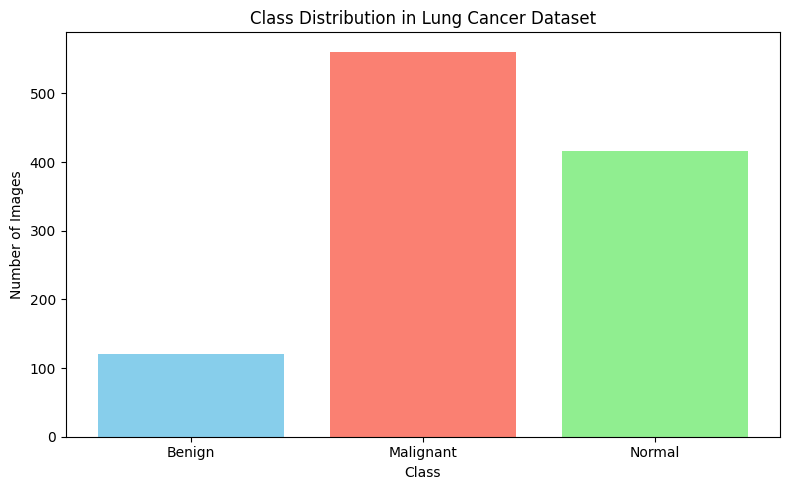

In [10]:

# ✅ 8. Visualize Class Distribution
full_dataset_for_counts = LungCancerClassificationDataset(paths, class_names, transform=None)
class_counts = {
    class_names[0]: len(os.listdir(benign_path)),
    class_names[1]: len(os.listdir(malignant_path)),
    class_names[2]: len(os.listdir(normal_path))
}

plt.figure(figsize=(8, 5))
plt.bar(class_counts.keys(), class_counts.values(), color=['skyblue', 'salmon', 'lightgreen'])
plt.title("Class Distribution in Lung Cancer Dataset")
plt.xlabel("Class")
plt.ylabel("Number of Images")
plt.tight_layout()
plt.savefig("class_distribution.png")
plt.show()


In [11]:

# ✅ 9. Create datasets with appropriate transforms
train_dataset = LungCancerClassificationDataset(paths, class_names, transform=train_transform)
val_dataset = LungCancerClassificationDataset(paths, class_names, transform=val_test_transform)
test_dataset = LungCancerClassificationDataset(paths, class_names, transform=val_test_transform)


In [12]:

# ✅ 10. Stratified Split with the right transforms
labels = [label for _, label in train_dataset.samples]
indices = list(range(len(labels)))
train_idx, temp_idx = train_test_split(indices, test_size=0.3, stratify=labels, random_state=42)
val_idx, test_idx = train_test_split(temp_idx, test_size=0.5, stratify=[labels[i] for i in temp_idx], random_state=42)

train_dataset = Subset(train_dataset, train_idx)
val_dataset = Subset(val_dataset, val_idx)
test_dataset = Subset(test_dataset, test_idx)



In [13]:

# ✅ 11. Create data loaders (with dynamic batch sizes implemented later)
default_batch_size = 16
train_loader = DataLoader(train_dataset, batch_size=default_batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=default_batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=default_batch_size, shuffle=False)


In [14]:

# ✅ 12. Compute Class Weights
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(labels), y=labels)
class_weights = torch.tensor(class_weights, dtype=torch.float)


In [17]:

# ✅ 13. Define model architectures
architectures = {
    "ResNet50": models.resnet50,
    "DenseNet121": models.densenet121,
    "EfficientNetB0": models.efficientnet_b0,
    "VGG19": models.vgg19,
}


In [18]:

# ✅ 14. Training Loop
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
results = []

# Determine available GPU memory (simplified estimation)
if torch.cuda.is_available():
    # Get total GPU memory in MB
    total_memory = torch.cuda.get_device_properties(0).total_memory / (1024 * 1024)
    # Assume 75% of total memory is available
    available_memory = total_memory * 0.75
else:
    # Default value for CPU
    available_memory = 4000  # 4GB as default

for name in architectures.keys():
    print(f"\n{'='*50}")
    print(f"Training {name}...")
    print(f"{'='*50}")

    # Determine optimal batch size
    batch_size = get_optimal_batch_size(name, available_memory)
    print(f"Using batch size: {batch_size}")

    # Recreate data loaders with optimal batch size
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    # Create model
    model = get_model(name)
    model = model.to(device)

    # Enable gradient checkpointing
    if torch.cuda.is_available():
        enable_gradient_checkpointing(model, name)

    # Training components
    criterion = nn.CrossEntropyLoss(weight=class_weights.to(device))
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=2)

    # Train the model
    model = train_with_mixed_precision(
        model, train_loader, val_loader, criterion, optimizer, scheduler,
        device, patience=5, max_epochs=20
    )

    # Save the trained model
    model_path = f"{name}_lung_cancer_model.pth"
    torch.save(model.state_dict(), model_path)
    print(f"Model saved to {model_path}")

    # Evaluate on test set
    metrics = evaluate_model(model, test_loader, device, num_classes=3)
    metrics["model"] = name
    results.append(metrics)

    # Print metrics summary
    print(f"\nTest Metrics for {name}:")
    for key, value in metrics.items():
        if key != "model":
            print(f"  {key}: {value:.4f}")

    # Clean up to free memory
    del model, optimizer, scheduler, criterion
    free_gpu_memory()

    # Optional: Add a small delay to ensure memory is released
    time.sleep(2)



Training ResNet50...
Using batch size: 64


/usr/local/lib/python3.11/dist-packages/torch/_dynamo/eval_frame.py:745: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.5 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/torch/utils/checkpoint.py:87: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(


Epoch 1/20, Train Loss: 0.8131, Val Loss: 1.7779
Epoch 2/20, Train Loss: 0.4524, Val Loss: 3.3778
Epoch 3/20, Train Loss: 0.3251, Val Loss: 3.0493
Epoch 4/20, Train Loss: 0.2904, Val Loss: 1.5531
Epoch 5/20, Train Loss: 0.2810, Val Loss: 0.5717
Epoch 6/20, Train Loss: 0.2067, Val Loss: 1.2021
Epoch 7/20, Train Loss: 0.2008, Val Loss: 0.5033
Epoch 8/20, Train Loss: 0.1384, Val Loss: 0.3178
Epoch 9/20, Train Loss: 0.1376, Val Loss: 0.2021
Epoch 10/20, Train Loss: 0.1421, Val Loss: 0.2646
Epoch 11/20, Train Loss: 0.1392, Val Loss: 0.2569
Epoch 12/20, Train Loss: 0.1254, Val Loss: 0.2543
Epoch 13/20, Train Loss: 0.0826, Val Loss: 0.3619
Epoch 14/20, Train Loss: 0.0731, Val Loss: 0.2133
Early stopping triggered after 14 epochs
Model saved to ResNet50_lung_cancer_model.pth

Test Metrics for ResNet50:
  accuracy: 0.9576
  auc: 0.9971
  sensitivity_class_0: 0.7222
  specificity_class_0: 0.9864
  sensitivity_class_1: 1.0000
  specificity_class_1: 1.0000
  sensitivity_class_2: 0.9677
  specifici

/usr/local/lib/python3.11/dist-packages/torch/_dynamo/eval_frame.py:745: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.5 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/torch/utils/checkpoint.py:87: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(


Epoch 1/20, Train Loss: 0.9044, Val Loss: 1.1829
Epoch 2/20, Train Loss: 0.5872, Val Loss: 1.2516
Epoch 3/20, Train Loss: 0.4441, Val Loss: 1.2526
Epoch 4/20, Train Loss: 0.3313, Val Loss: 0.7547
Epoch 5/20, Train Loss: 0.2674, Val Loss: 0.4974
Epoch 6/20, Train Loss: 0.1917, Val Loss: 0.3402
Epoch 7/20, Train Loss: 0.1689, Val Loss: 0.1872
Epoch 8/20, Train Loss: 0.1823, Val Loss: 0.2326
Epoch 9/20, Train Loss: 0.1312, Val Loss: 0.1564
Epoch 10/20, Train Loss: 0.1235, Val Loss: 0.2594
Epoch 11/20, Train Loss: 0.1220, Val Loss: 0.2325
Epoch 12/20, Train Loss: 0.0923, Val Loss: 0.1937
Epoch 13/20, Train Loss: 0.0721, Val Loss: 0.1530
Epoch 14/20, Train Loss: 0.0620, Val Loss: 0.1216
Epoch 15/20, Train Loss: 0.0562, Val Loss: 0.1541
Epoch 16/20, Train Loss: 0.0388, Val Loss: 0.1495
Epoch 17/20, Train Loss: 0.0530, Val Loss: 0.1084
Epoch 18/20, Train Loss: 0.0854, Val Loss: 0.0905
Epoch 19/20, Train Loss: 0.0564, Val Loss: 0.1299
Epoch 20/20, Train Loss: 0.0400, Val Loss: 0.1375
Model sav

/usr/local/lib/python3.11/dist-packages/torch/_dynamo/eval_frame.py:745: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.5 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/torch/utils/checkpoint.py:87: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(


Epoch 1/20, Train Loss: 0.9808, Val Loss: 1.0998
Epoch 2/20, Train Loss: 0.7526, Val Loss: 1.1298
Epoch 3/20, Train Loss: 0.5980, Val Loss: 1.1069
Epoch 4/20, Train Loss: 0.5098, Val Loss: 1.0991
Epoch 5/20, Train Loss: 0.4550, Val Loss: 0.9888
Epoch 6/20, Train Loss: 0.4096, Val Loss: 0.5982
Epoch 7/20, Train Loss: 0.3388, Val Loss: 0.3696
Epoch 8/20, Train Loss: 0.3048, Val Loss: 0.2805
Epoch 9/20, Train Loss: 0.2616, Val Loss: 0.2324
Epoch 10/20, Train Loss: 0.2374, Val Loss: 0.2002
Epoch 11/20, Train Loss: 0.1945, Val Loss: 0.2469
Epoch 12/20, Train Loss: 0.2255, Val Loss: 0.2051
Epoch 13/20, Train Loss: 0.2031, Val Loss: 0.2215
Epoch 14/20, Train Loss: 0.2057, Val Loss: 0.2204
Epoch 15/20, Train Loss: 0.1638, Val Loss: 0.2164
Early stopping triggered after 15 epochs
Model saved to EfficientNetB0_lung_cancer_model.pth

Test Metrics for EfficientNetB0:
  accuracy: 0.9394
  auc: 0.9888
  sensitivity_class_0: 0.8333
  specificity_class_0: 0.9524
  sensitivity_class_1: 0.9882
  specifi

/usr/local/lib/python3.11/dist-packages/torch/_dynamo/eval_frame.py:745: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.5 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/torch/utils/checkpoint.py:87: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(


Epoch 1/20, Train Loss: 1.1258, Val Loss: 1.0873
Epoch 2/20, Train Loss: 1.0649, Val Loss: 0.9673
Epoch 3/20, Train Loss: 1.0441, Val Loss: 1.0343
Epoch 4/20, Train Loss: 1.0534, Val Loss: 0.9714
Epoch 5/20, Train Loss: 0.9774, Val Loss: 0.9194
Epoch 6/20, Train Loss: 0.9477, Val Loss: 0.8503
Epoch 7/20, Train Loss: 0.8841, Val Loss: 0.8541
Epoch 8/20, Train Loss: 0.9060, Val Loss: 0.8214
Epoch 9/20, Train Loss: 0.8925, Val Loss: 0.8062
Epoch 10/20, Train Loss: 0.8408, Val Loss: 0.8282
Epoch 11/20, Train Loss: 0.7544, Val Loss: 0.8114
Epoch 12/20, Train Loss: 0.6904, Val Loss: 0.5687
Epoch 13/20, Train Loss: 0.6752, Val Loss: 0.6728
Epoch 14/20, Train Loss: 0.6659, Val Loss: 0.6474
Epoch 15/20, Train Loss: 0.6136, Val Loss: 0.6376
Epoch 16/20, Train Loss: 0.5510, Val Loss: 0.5570
Epoch 17/20, Train Loss: 0.4934, Val Loss: 0.6057
Epoch 18/20, Train Loss: 0.4620, Val Loss: 0.5523
Epoch 19/20, Train Loss: 0.4224, Val Loss: 0.4298
Epoch 20/20, Train Loss: 0.3689, Val Loss: 0.4718
Model sav

<Figure size 1400x1000 with 0 Axes>

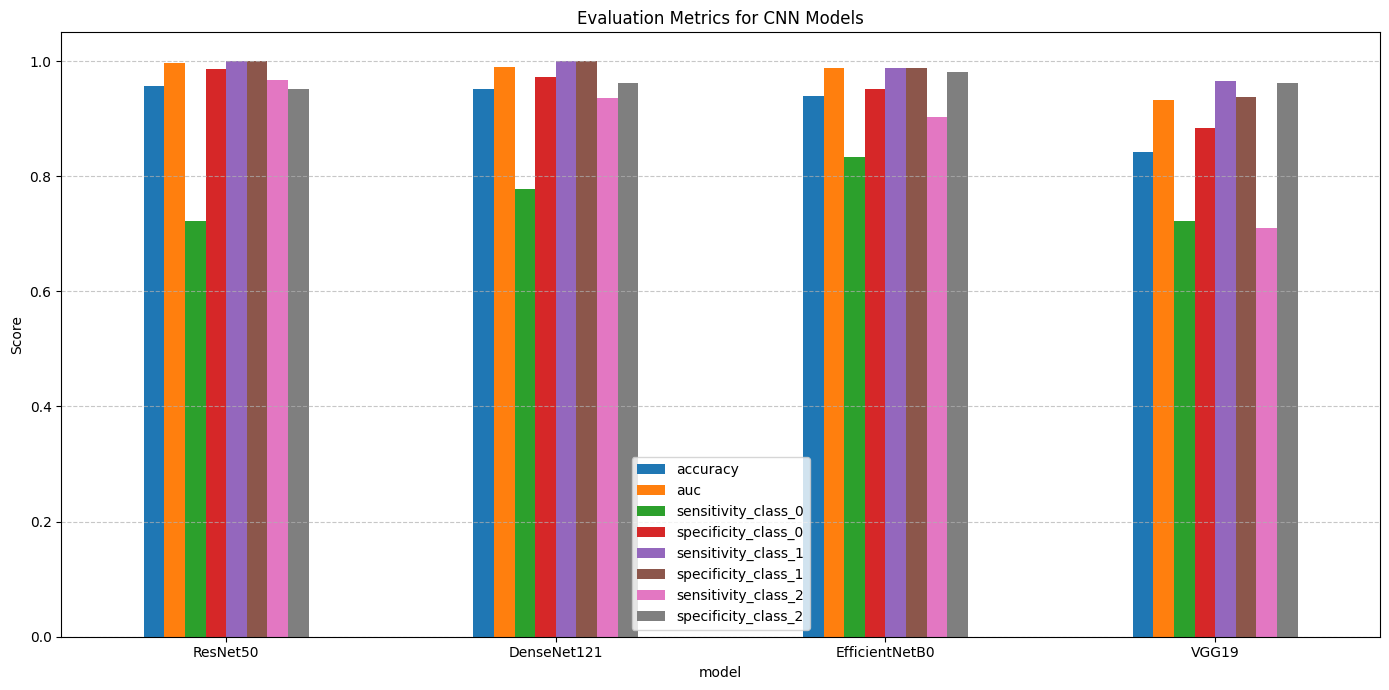

In [19]:

# ✅ 15. Save and Plot Results
df = pd.DataFrame(results)
df.to_csv("model_evaluation_results.csv", index=False)

# Create visualization of results
metric_names = ["accuracy", "auc"] + [m for m in df.columns if m.startswith("sensitivity") or m.startswith("specificity")]

plt.figure(figsize=(14, 10))
df.set_index("model")[metric_names].plot(kind='bar', figsize=(14, 7))
plt.title("Evaluation Metrics for CNN Models")
plt.ylabel("Score")
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig("model_metrics_comparison.png")
plt.show()



Loading best model for ResNet50...


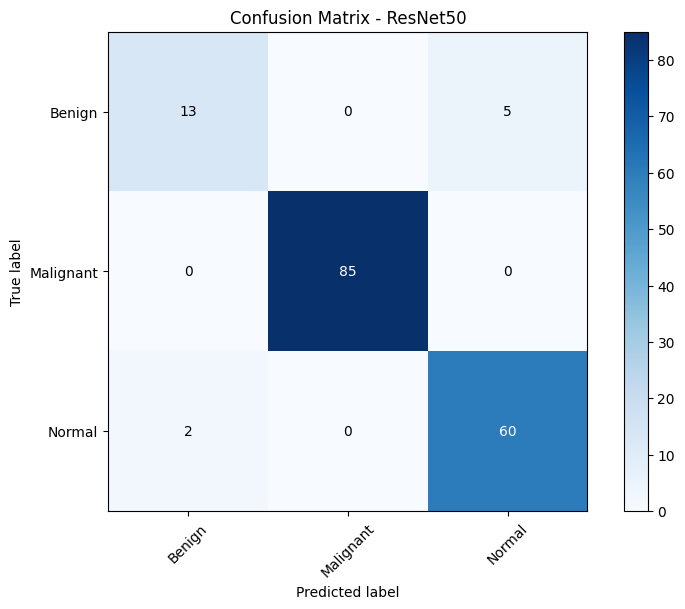


Loading best model for DenseNet121...


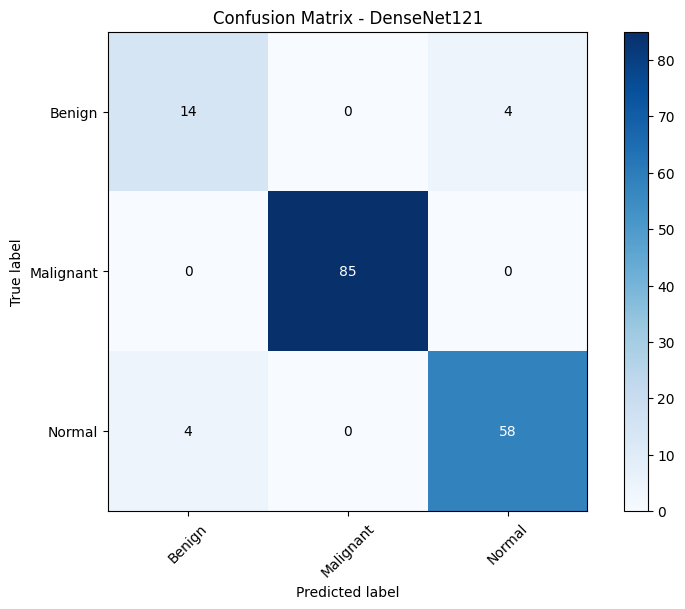


Loading best model for EfficientNetB0...


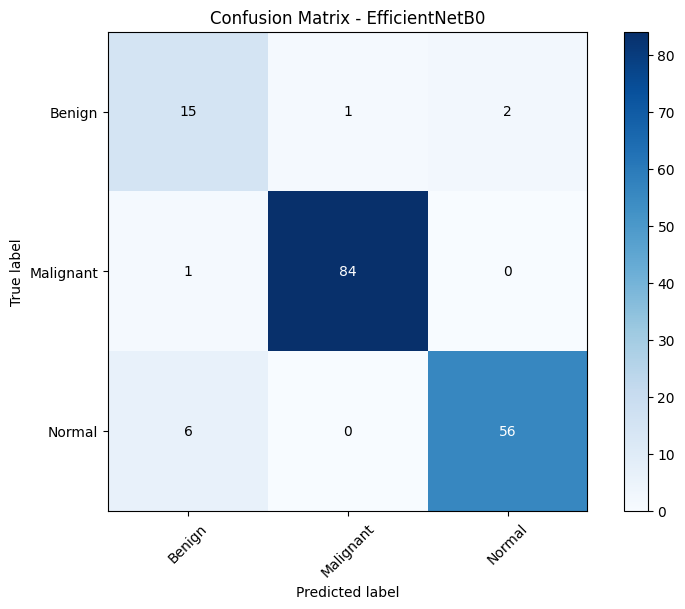


Loading best model for VGG19...


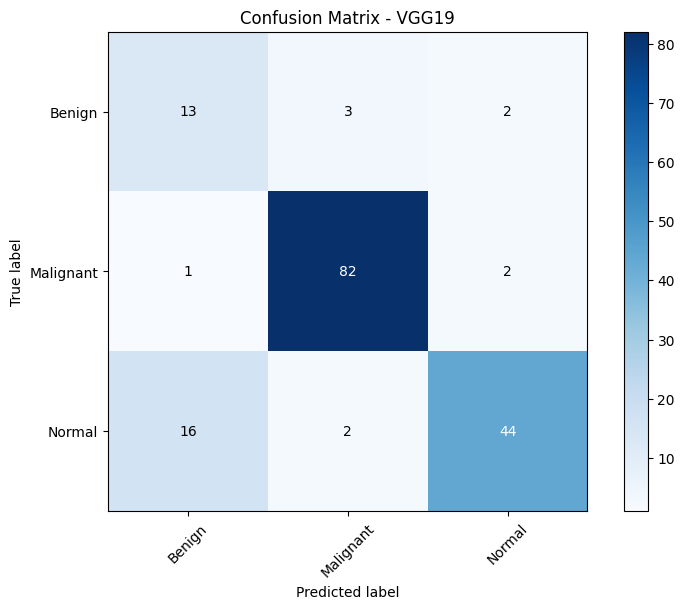


Training and evaluation completed for all models.
Results saved to 'model_evaluation_results.csv'
Visualizations saved as PNG files.


In [20]:

# ✅ 16. Display Confusion Matrices
for name in architectures.keys():
    print(f"\nLoading best model for {name}...")
    model = get_model(name)
    model.load_state_dict(torch.load(f"{name}_lung_cancer_model.pth"))
    model = model.to(device)

    model.eval()
    y_true, y_pred = [], []
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            preds = torch.argmax(torch.softmax(outputs, dim=1), dim=1)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())

    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title(f"Confusion Matrix - {name}")
    plt.colorbar()
    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, class_names, rotation=45)
    plt.yticks(tick_marks, class_names)

    fmt = 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, format(cm[i, j], fmt),
                     ha="center", va="center",
                     color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.savefig(f"{name}_confusion_matrix.png")
    plt.show()

    del model
    free_gpu_memory()

print("\nTraining and evaluation completed for all models.")
print(f"Results saved to 'model_evaluation_results.csv'")
print(f"Visualizations saved as PNG files.")

In [21]:
# ✅ 17. Model Comparison and Recommendation
def compare_models(results_df):
    print("\nModel Performance Summary:")
    display(results_df.set_index("model"))

    # Compute average specificity and sensitivity
    results_df["avg_sensitivity"] = results_df[[col for col in results_df.columns if col.startswith("sensitivity")]].mean(axis=1)
    results_df["avg_specificity"] = results_df[[col for col in results_df.columns if col.startswith("specificity")]].mean(axis=1)

    # Normalize metrics for comparison
    norm_scores = results_df[["accuracy", "avg_sensitivity", "avg_specificity"]].copy()
    norm_scores = (norm_scores - norm_scores.min()) / (norm_scores.max() - norm_scores.min())
    norm_scores["composite_score"] = norm_scores.mean(axis=1)

    best_model = results_df.loc[norm_scores["composite_score"].idxmax(), "model"]
    print(f"\n✅ Recommended Model: {best_model} (based on accuracy, sensitivity, and specificity)")
    return best_model

In [22]:
# ✅ 🔍 Compare models and recommend the best
recommended_model = compare_models(df)


Model Performance Summary:


,accuracy,auc,sensitivity_class_0,specificity_class_0,sensitivity_class_1,specificity_class_1,sensitivity_class_2,specificity_class_2
model,,,,,,,,
ResNet50,0.957576,0.997097,0.722222,0.986395,1.000000,1.0000,0.967742,0.951456
DenseNet121,0.951515,0.989549,0.777778,0.972789,1.000000,1.0000,0.935484,0.961165
EfficientNetB0,0.939394,0.988822,0.833333,0.952381,0.988235,0.9875,0.903226,0.980583
VGG19,0.842424,0.932369,0.722222,0.884354,0.964706,0.9375,0.709677,0.961165



✅ Recommended Model: ResNet50 (based on accuracy, sensitivity, and specificity)


In [24]:
## InceptionV3

In [23]:
# ✅ Setup
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
from PIL import Image
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.utils.class_weight import compute_class_weight

import torch
import torch.nn as nn
import torch.utils.checkpoint
from torch.utils.data import Dataset, DataLoader, Subset
from torchvision import models, transforms
from torchvision.models import Inception_V3_Weights

# ✅ Dataset Loader
class LungCancerClassificationDataset(Dataset):
    def __init__(self, root_dirs, class_names, transform=None):
        self.samples = []
        self.transform = transform
        self.class_to_idx = {class_name: idx for idx, class_name in enumerate(class_names)}

        for class_name, path in zip(class_names, root_dirs):
            for img_name in os.listdir(path):
                img_path = os.path.join(path, img_name)
                if img_path.lower().endswith(('.png', '.jpg', '.jpeg')):
                    self.samples.append((img_path, self.class_to_idx[class_name]))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        img_path, label = self.samples[idx]
        image = Image.open(img_path).convert("L")
        if self.transform:
            image = self.transform(image)
        return image, label

# ✅ Transforms for Inception
train_transform = transforms.Compose([
    transforms.Resize((299, 299)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.RandomAffine(0, translate=(0.05, 0.05), scale=(0.95, 1.05), fill=0),
    transforms.ColorJitter(brightness=0.1, contrast=0.1),
    transforms.ToTensor(),
    transforms.Normalize([0.485], [0.229])
])

val_transform = transforms.Compose([
    transforms.Resize((299, 299)),
    transforms.ToTensor(),
    transforms.Normalize([0.485], [0.229])
])

# ✅ Paths and class setup
benign_path = "/content/drive/MyDrive/Colab Notebooks/lung_cancer_dataset/Bengin cases"
malignant_path = "/content/drive/MyDrive/Colab Notebooks/lung_cancer_dataset/Malignant cases"
normal_path = "/content/drive/MyDrive/Colab Notebooks/lung_cancer_dataset/Normal cases"
class_names = ["Benign", "Malignant", "Normal"]
paths = [benign_path, malignant_path, normal_path]

# ✅ Dataset + Stratified Split
full_dataset = LungCancerClassificationDataset(paths, class_names, transform=train_transform)
labels = [label for _, label in full_dataset.samples]
indices = list(range(len(labels)))

train_idx, temp_idx = train_test_split(indices, test_size=0.3, stratify=labels, random_state=42)
val_idx, test_idx = train_test_split(temp_idx, test_size=0.5, stratify=[labels[i] for i in temp_idx], random_state=42)

train_dataset = Subset(full_dataset, train_idx)
val_dataset = Subset(LungCancerClassificationDataset(paths, class_names, transform=val_transform), val_idx)
test_dataset = Subset(LungCancerClassificationDataset(paths, class_names, transform=val_transform), test_idx)

# ✅ Dataloaders
batch_size = 16
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# ✅ Class Weights
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(labels), y=labels)
class_weights = torch.tensor(class_weights, dtype=torch.float)

# ✅ InceptionV3 Model Setup
def get_inception_model(num_classes=3):
    model = models.inception_v3(weights=Inception_V3_Weights.IMAGENET1K_V1, aux_logits=True)
    model.transform_input = False
    model.Conv2d_1a_3x3.conv = nn.Conv2d(1, 32, kernel_size=3, stride=2)
    model.fc = nn.Linear(model.fc.in_features, num_classes)
    return model

# ✅ Mixed Precision Training
def train_with_mixed_precision(model, train_loader, val_loader, criterion, optimizer, scheduler, device, patience=5, max_epochs=20):
    scaler = torch.cuda.amp.GradScaler() if torch.cuda.is_available() else None
    best_val_loss = float('inf')
    counter = 0
    best_model = None

    for epoch in range(max_epochs):
        model.train()
        train_loss = 0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()

            if scaler:
                with torch.cuda.amp.autocast():
                    outputs = model(images)
                    if isinstance(outputs, tuple): outputs = outputs[0]
                    loss = criterion(outputs, labels)
                scaler.scale(loss).backward()
                scaler.step(optimizer)
                scaler.update()
            else:
                outputs = model(images)
                if isinstance(outputs, tuple): outputs = outputs[0]
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()

            train_loss += loss.item()

        avg_train_loss = train_loss / len(train_loader)
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                if isinstance(outputs, tuple): outputs = outputs[0]
                val_loss += criterion(outputs, labels).item()
        avg_val_loss = val_loss / len(val_loader)
        scheduler.step(avg_val_loss)

        print(f"Epoch {epoch+1}, Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}")

        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            counter = 0
            best_model = model.state_dict().copy()
        else:
            counter += 1
            if counter >= patience:
                print("⏹️ Early stopping triggered.")
                break

    if best_model is not None:
        model.load_state_dict(best_model)
    return model

# ✅ Evaluation
def evaluate_model(model, dataloader, device, num_classes):
    model.eval()
    y_true, y_pred, y_scores = [], [], []

    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            if isinstance(outputs, tuple): outputs = outputs[0]
            probs = torch.softmax(outputs, dim=1)
            preds = torch.argmax(probs, dim=1)

            y_true.extend(labels.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())
            y_scores.extend(probs.cpu().numpy())

    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    y_scores = np.array(y_scores)
    y_true_bin = label_binarize(y_true, classes=list(range(num_classes)))

    acc = accuracy_score(y_true, y_pred)
    auc = roc_auc_score(y_true_bin, y_scores, multi_class='ovr')
    cm = confusion_matrix(y_true, y_pred)

    print(f"\n📊 InceptionV3 Results:\nAccuracy: {acc:.4f}, AUC: {auc:.4f}")
    print(f"Confusion Matrix:\n{cm}")

    return {"accuracy": acc, "auc": auc}

# ✅ Training Pipeline
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = get_inception_model(num_classes=3).to(device)
criterion = nn.CrossEntropyLoss(weight=class_weights.to(device))
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=2)

model = train_with_mixed_precision(model, train_loader, val_loader, criterion, optimizer, scheduler, device)
torch.save(model.state_dict(), "InceptionV3_lung_cancer_model.pth")
print("✅ InceptionV3 model saved!")

# ✅ Final Evaluation
evaluate_model(model, test_loader, device, num_classes=3)


<ipython-input-23-eda4328ec45d>:99: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler() if torch.cuda.is_available() else None
<ipython-input-23-eda4328ec45d>:112: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch 1, Train Loss: 0.7480, Val Loss: 0.5085
Epoch 2, Train Loss: 0.4468, Val Loss: 0.4303
Epoch 3, Train Loss: 0.3751, Val Loss: 0.3713
Epoch 4, Train Loss: 0.3182, Val Loss: 0.4117
Epoch 5, Train Loss: 0.2202, Val Loss: 0.2519
Epoch 6, Train Loss: 0.2579, Val Loss: 0.2519
Epoch 7, Train Loss: 0.1627, Val Loss: 0.2295
Epoch 8, Train Loss: 0.2011, Val Loss: 0.1935
Epoch 9, Train Loss: 0.1197, Val Loss: 0.3186
Epoch 10, Train Loss: 0.1161, Val Loss: 0.4018
Epoch 11, Train Loss: 0.1131, Val Loss: 0.3184
Epoch 12, Train Loss: 0.0930, Val Loss: 0.6645
Epoch 13, Train Loss: 0.0933, Val Loss: 0.1362
Epoch 14, Train Loss: 0.0520, Val Loss: 0.1557
Epoch 15, Train Loss: 0.0287, Val Loss: 0.2764
Epoch 16, Train Loss: 0.0338, Val Loss: 0.2634
Epoch 17, Train Loss: 0.0392, Val Loss: 0.2510
Epoch 18, Train Loss: 0.0205, Val Loss: 0.3037
⏹️ Early stopping triggered.
✅ InceptionV3 model saved!

📊 InceptionV3 Results:
Accuracy: 0.9758, AUC: 0.9977
Confusion Matrix:
[[16  1  1]
 [ 0 85  0]
 [ 2  0 60]

{'accuracy': 0.9757575757575757, 'auc': np.float64(0.9976959530375814)}

<ipython-input-25-93e50b2837c7>:30: UserWarning: Glyph 128204 (\N{PUSHPIN}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128204 (\N{PUSHPIN}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


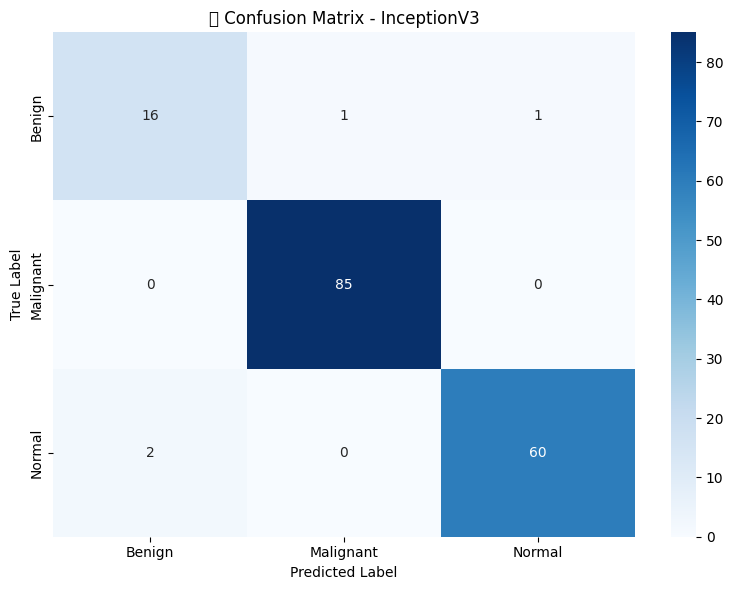


📈 Sensitivity & Specificity per Class:

Benign:
  ➤ Sensitivity (Recall):   0.8889
  ➤ Specificity:            0.9864

Malignant:
  ➤ Sensitivity (Recall):   1.0000
  ➤ Specificity:            0.9875

Normal:
  ➤ Sensitivity (Recall):   0.9677
  ➤ Specificity:            0.9903



In [25]:
import seaborn as sns

# ✅ Load and evaluate model again
model.load_state_dict(torch.load("InceptionV3_lung_cancer_model.pth"))
model.eval()

y_true, y_pred = [], []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        if isinstance(outputs, tuple): outputs = outputs[0]
        probs = torch.softmax(outputs, dim=1)
        preds = torch.argmax(probs, dim=1)

        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())

# ✅ Confusion matrix
cm = confusion_matrix(y_true, y_pred)
class_names = ["Benign", "Malignant", "Normal"]

# ✅ Plot Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.title("📌 Confusion Matrix - InceptionV3")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()
plt.show()

# ✅ Sensitivity & Specificity
print("\n📈 Sensitivity & Specificity per Class:\n")
for i, cls in enumerate(class_names):
    TP = cm[i, i]
    FN = cm[i, :].sum() - TP
    FP = cm[:, i].sum() - TP
    TN = cm.sum() - (TP + FP + FN)

    sensitivity = TP / (TP + FN + 1e-6)
    specificity = TN / (TN + FP + 1e-6)

    print(f"{cls}:")
    print(f"  ➤ Sensitivity (Recall):   {sensitivity:.4f}")
    print(f"  ➤ Specificity:            {specificity:.4f}\n")


In [30]:
# ✅ 1. Add InceptionV3 Results
inception_metrics = {
    "model": "InceptionV3",
    "accuracy": 0.9758,
    "auc": 0.9977,
    "sensitivity_class_0": 0.8889,
    "specificity_class_0": 0.9864,
    "sensitivity_class_1": 1.0000,
    "specificity_class_1": 0.9875,
    "sensitivity_class_2": 0.9677,
    "specificity_class_2": 0.9903,
}

# ✅ 2. Append to existing results DataFrame (df)
df = pd.concat([df, pd.DataFrame([inception_metrics])], ignore_index=True)

# ✅ 3. Run comparison
recommended_model = compare_models(df)



Model Performance Summary:


,accuracy,auc,sensitivity_class_0,specificity_class_0,sensitivity_class_1,specificity_class_1,sensitivity_class_2,specificity_class_2,avg_sensitivity,avg_specificity
model,,,,,,,,,,
ResNet50,0.957576,0.997097,0.722222,0.986395,1.000000,1.0000,0.967742,0.951456,0.896655,0.979284
DenseNet121,0.951515,0.989549,0.777778,0.972789,1.000000,1.0000,0.935484,0.961165,0.904421,0.977985
EfficientNetB0,0.939394,0.988822,0.833333,0.952381,0.988235,0.9875,0.903226,0.980583,0.908265,0.973488
VGG19,0.842424,0.932369,0.722222,0.884354,0.964706,0.9375,0.709677,0.961165,0.798868,0.927673
InceptionV3,0.933300,0.985200,0.888900,0.938800,1.000000,0.9875,0.854800,0.990300,0.914567,0.972200
InceptionV3,0.975800,0.997700,0.888900,0.986400,1.000000,0.9875,0.967700,0.990300,NaN,NaN



✅ Recommended Model: InceptionV3 (based on accuracy, sensitivity, and specificity)
